In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

### Data Load

In [469]:
def cal_log_price(data):
    data = data.pct_change().apply(lambda x: np.log(1+x)).iloc[1:,:]
    return data

In [470]:
import yfinance as yf

# S&P 500 섹터 지수 심볼 리스트
symbols = [   # S&P 500 지수
    "XLK",     # 기술 섹터
    "XLC",     # 소프트웨어 및 커뮤니케이션 서비스 섹터
    "XLY",     # 소비자 서비스 섹터
    "XLP",     # 소비자 필수 용품 섹터
    "XLE",     # 에너지 섹터
    "XLF",     # 금융 섹터
    "XLV",     # 건강 관리 섹터
    "XLI",     # 산업 섹터
    "XLB",     # 소재 섹터
    "XLU"      # 공공 서비스 섹터
]

# 데이터 다운로드
data = yf.download(symbols, start="1999-01-01", end="2024-01-01")

[*********************100%%**********************]  10 of 10 completed


In [471]:
# 다양한 컬럼 중에서 수정종가만 인덱싱
daily_data = pd.DataFrame(data["Adj Close"]) 
# 데이터 pandas 데이터 형식으로 변환
daily_data.index = pd.DatetimeIndex(daily_data.index).strftime('%Y-%m-%d %H:%M:%S')
#주간 데이터로 변환(들고 올 때 부터 주간으로 들고 올 수 있는데 이러면 날짜 인덱싱이 어려움)
weekly_data = daily_data.rolling(window=5).mean().iloc[4::5]

weekly_data.index = pd.to_datetime(weekly_data.index)

In [472]:
weekly_data.dropna(axis=1, inplace=True)
#log price 변환
weekly_data_log = cal_log_price(weekly_data)

In [473]:
daily_data_log = cal_log_price(daily_data)

### 데이터 Maker

In [125]:
def datamaker(data,IS,OS,col_num=0,window=1000):
    return data.iloc[-window:,col_num]


In [124]:
weekly_data

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
1999-01-08,12.782729,12.441175,11.972251,15.868192,25.817183,15.108136,12.523823,18.412255,20.044230
1999-01-15,12.759545,12.046898,11.712992,15.563337,25.967894,14.591667,12.282904,18.587856,19.739965
1999-01-25,12.251303,11.894115,11.535521,15.298338,26.794476,14.242132,12.525118,18.826332,19.768049
1999-02-01,12.108639,11.512976,11.547868,15.403941,27.988422,14.736001,12.257001,18.824168,20.418716
1999-02-08,12.429634,11.782402,11.313298,15.513528,27.442085,14.793390,11.978519,18.843674,20.414037
...,...,...,...,...,...,...,...,...,...
2023-11-24,79.811613,83.247200,34.883315,105.060721,183.567206,68.796138,61.279668,128.687062,167.142279
2023-12-01,81.052455,83.103746,35.307606,105.675447,184.244595,69.420767,61.814176,129.504434,168.706067
2023-12-08,80.797157,81.211363,35.672421,107.688179,183.758475,69.464120,62.238636,130.922946,170.873465


### 데이터 분석

(array([22., 23., 24., 35., 43., 37., 57., 20., 20., 19.]),
 array([12.49119492, 13.73718697, 14.98317902, 16.22917107, 17.47516312,
        18.72115517, 19.96714722, 21.21313927, 22.45913132, 23.70512337,
        24.95111542]),
 <BarContainer object of 10 artists>)

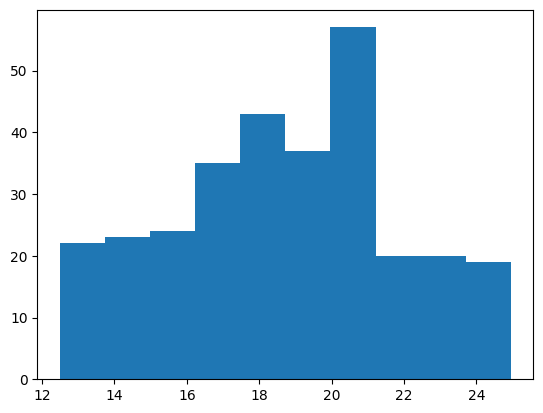

In [122]:
plt.hist(weekly_data.iloc[100:400,3])

(array([ 4.,  4.,  1.,  1.,  0.,  2., 18., 26., 30., 14.]),
 array([15.32787285, 16.76823811, 18.20860336, 19.64896862, 21.08933388,
        22.52969913, 23.97006439, 25.41042965, 26.85079491, 28.29116016,
        29.73152542]),
 <BarContainer object of 10 artists>)

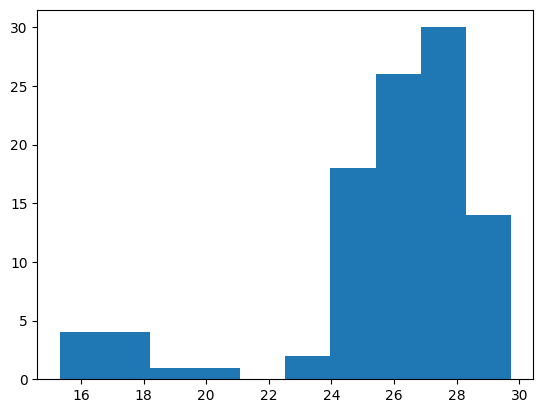

In [123]:
plt.hist(weekly_data.iloc[400:500,3])

## Clustering
### 다양한 클러스터 모델을 사용해서 IS(In Sample) OS(Out Sample) 기간의 군집이 차이나는지 확인 
IS OS를 분리해서 보는 이유는 전체적으로 봤을때 IS 길이가 더 길기에 구별됨에도 그 영향이 작게 보일 수 있기 때문이다

### GMM

In [474]:
daily_data.dropna(axis=1, inplace=True)
daily_data_log.dropna(axis=1, inplace=True)

In [475]:
daily_data = daily_data.mean(axis=1)
daily_data_log = daily_data_log.mean(axis=1)

In [476]:
position = daily_data.index.get_loc('2008-09-15 00:00:00')
position

2439

In [504]:
def cal_period(position):
    IS = np.array(daily_data[position-252:position]).reshape(-1,1)
    OS = np.array(daily_data[position:position+100]).reshape(-1,1)
    IS_OS = np.array(daily_data[position-252:position+100])
    IS_log = np.array(daily_data_log[position-252:position]).reshape(-1,1)
    OS_log  = np.array(daily_data_log[position:position+100]).reshape(-1,1)
    IS_OS_log = np.array(daily_data_log[position-252:position+100]).reshape(-1,1)
    return IS, OS,IS_OS ,IS_log, OS_log, IS_OS_log


In [505]:
IS, OS,IS_OS ,IS_log, OS_log, IS_OS_log = cal_period(position = daily_data.index.get_loc('2020-03-02 00:00:00'))

In [501]:
def GMM_AIC_BIC(data,title):
    aic_values = []
    bic_values = []
    X = data
    # 클러스터 개수를 변경하면서 AIC와 BIC 값을 계산합니다.
    for n_components in range(1, 11):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        aic_values.append(gmm.aic(X))
        bic_values.append(gmm.bic(X))
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), aic_values, marker='o', label='AIC')
    plt.plot(range(1, 11), bic_values, marker='s', label='BIC')
    plt.xlabel('Number of Components')
    plt.ylabel('Value')
    plt.title(title)
    plt.xticks(range(1, 11))
    plt.legend()
    plt.grid(True)
    plt.show()
    print('min AIC index:',np.argmin(aic_values))
    print('min AIC value:',np.min(aic_values))
    print('min BIC index:',np.argmin(bic_values))
    print('min BIC values:',np.min(bic_values))
def func_IS_OS(IS,OS):
    GMM_AIC_BIC(IS,'IS_2020')
    GMM_AIC_BIC(OS,'OS_Log_2020')

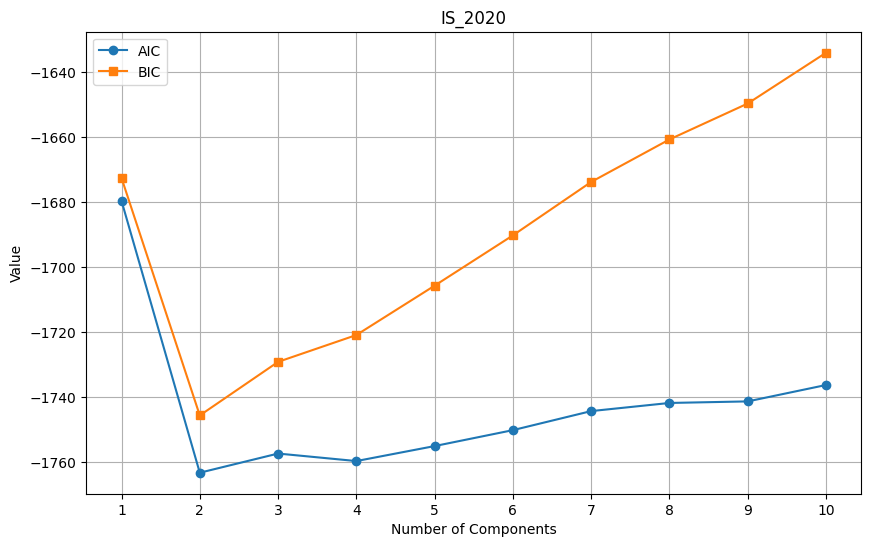

min AIC index: 1
min AIC value: -1763.281860793556
min BIC index: 1
min BIC values: -1745.6347153559989


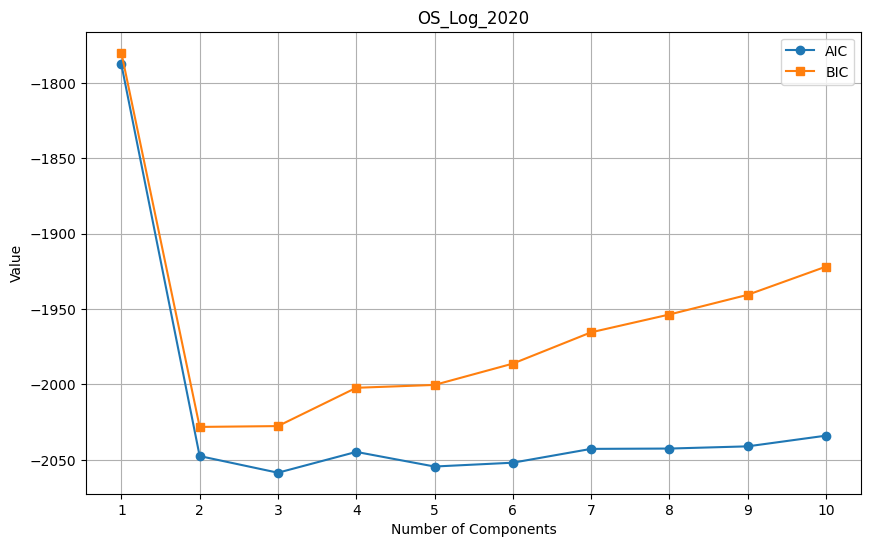

min AIC index: 2
min AIC value: -2058.4853363298835
min BIC index: 1
min BIC values: -2028.120011491342


In [502]:
func_IS_OS(IS_log,IS_OS_log)

----

## Simulation model

### MCMC 모델링

In [177]:
def GBM_PDF(s,mu,sigma,S0,t=1):
    import numpy as np
    """
    기하 브라운 운동의 확률 밀도 함수를 계산

    Parameters:
    s (float): 자산 가격
    S0 (float): 초기 자산 가격
    mu (float): 드리프트(평균 성장률)
    sigma (float): 변동성(표준 편차)
    t (float): 시간
    """
    if s <= 0 or t <= 0:
        return 0.0
    
    term1 = 1 / (s * sigma * np.sqrt(2 * np.pi * t))
    exponent = -(np.log(s / S0) - (mu - 0.5 * sigma**2) * t)**2 / (2 * sigma**2 * t)
    term2 = np.exp(exponent)
    
    return term1 * term2


In [414]:
def log_likelihood(mu_proposal, sigma_proposal, data):

    MLE_list = []
    
    data_1 = data[1:]
    for i,data_1 in enumerate(data_1):
        data_inital = data[i]
        MLE_list.append(np.log(GBM_PDF(data_1,mu_proposal,sigma_proposal,data_inital)))
    return np.sum(MLE_list)

def metropolis_hastings(data, initial_params,iterations, proposal_width):
    mu_current, sigma_current = initial_params
    samples = []
    for _ in range(iterations):
        mu_proposal = np.random.normal(mu_current, proposal_width)
        sigma_proposal = np.abs(np.random.normal(sigma_current, proposal_width))
        
        # Calculate log-likelihoods
        ll_current = log_likelihood(mu_current, sigma_current, data)
        ll_proposal = log_likelihood(mu_proposal, sigma_proposal+0.0000001, data)
        
        # Calculate acceptance probability
        acceptance_prob = min(1, np.exp(ll_proposal - ll_current))
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_prob:
            mu_current = mu_proposal
            sigma_current = sigma_proposal
        
        samples.append((mu_current, sigma_current))
    
    return np.array(samples)

In [518]:
def estimated_para(data,initial_params,iterations,proposal_width):
    samples = metropolis_hastings(data, initial_params, iterations, proposal_width)

    # Extract and plot samples
    mu_samples = samples[:, 0]
    sigma_samples = samples[:, 1]

    estimated_mu = np.mean(mu_samples[int(iterations-iterations*0.4):iterations])
    estimated_sigma = np.mean(sigma_samples[int(iterations-iterations*0.4):iterations])
    return estimated_mu,estimated_sigma,mu_samples,sigma_samples
def ploting_para(estimated_mu,estimated_sigma,mu_samples,sigma_samples):
    print(f"Estimated mu: {estimated_mu}")
    print(f"Estimated sigma: {estimated_sigma}")

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(mu_samples, label='mu samples')

    ax[0].legend()

    ax[1].plot(sigma_samples, label='sigma samples')

    ax[1].legend()

    plt.tight_layout()
    plt.show()


In [416]:
IS = weekly_data.iloc[500:1000,1]
OS = weekly_data.iloc[1000:1200,1]
IS_OS = weekly_data.iloc[500:1200,1]

In [522]:
initial_params = [0, 0.1]
iterations = 1000
proposal_width = 0.1

estimated_mu_IS_OS,estimated_sigma_IS_OS,mu_samples_IS_OS,sigma_samples_IS_OS = estimated_para(IS_OS,initial_params,iterations,proposal_width)
estimated_mu_OS,estimated_sigma_OS,mu_samples_OS,sigma_samples_OS = estimated_para(OS,initial_params,iterations,proposal_width)
estimated_mu_IS,estimated_sigma_IS,mu_samples_IS,sigma_samples_IS = estimated_para(IS,initial_params,iterations,proposal_width)


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_881/1553238095.py:8: RuntimeWarning: divide by zero encountered in log
  MLE_list.append(np.log(GBM_PDF(data_1,mu_proposal,sigma_proposal,data_inital)))


Estimated mu: 0.006282422543958439
Estimated sigma: 0.019716239984356624


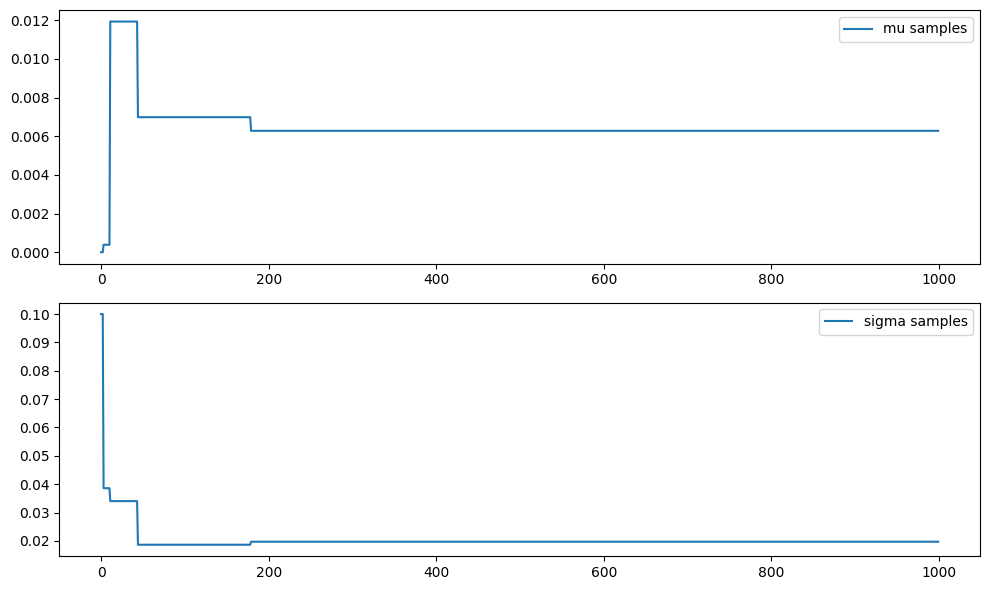

In [523]:
ploting_para(estimated_mu_IS_OS,estimated_sigma_IS_OS,mu_samples_IS_OS,sigma_samples_IS_OS)

In [507]:
import numpy as np
from scipy.stats import chi2
def para_hypo_test(estimated_mu_H0,estimated_sigma_H0,estimated_mu_H1,estimated_sigma_H1,OS):
    data = OS
    mu_0 = estimated_mu_H0
    sigma_0 = estimated_sigma_H0

    # MLE estimates from the sample
    mu_hat = estimated_mu_H1
    sigma_hat = estimated_sigma_H1

    
    # Log-likelihoods
    ll_null = log_likelihood(mu_0, sigma_0, data)
    ll_alternative = log_likelihood(mu_hat, sigma_hat, data)

    # Likelihood ratio test statistic
    likelihood_ratio = -2 * (ll_null - ll_alternative)

    # Critical value for chi-squared distribution with 2 degrees of freedom
    alpha = 0.1
    degrees_of_freedom = 1
    critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

    print("Likelihood Ratio Test Statistic:", likelihood_ratio)
    print("Critical Value (chi-squared with df=1):", critical_value)

    if likelihood_ratio > critical_value:
        print("Reject the null hypothesis.")
        return 
    else:
        print("Fail to reject the null hypothesis.")
    


In [525]:
# IS = weekly_data.iloc[500:1000,1]
# OS = weekly_data.iloc[1000:1500,1]
# IS_OS = weekly_data.iloc[500:1500,1]
IS, OS,IS_OS ,IS_log, OS_log, IS_OS_log = cal_period(position = daily_data.index.get_loc('2008-09-15 00:00:00'))
estimated_mu_IS_OS,estimated_sigma_IS_OS,mu_samples_IS_OS,sigma_samples_IS_OS = estimated_para(IS_OS,initial_params,iterations,proposal_width)
estimated_mu_OS,estimated_sigma_OS,mu_samples_OS,sigma_samples_OS = estimated_para(OS,initial_params,iterations,proposal_width)
estimated_mu_IS,estimated_sigma_IS,mu_samples_IS,sigma_samples_IS = estimated_para(IS,initial_params,iterations,proposal_width)
para_hypo_test(estimated_mu_IS,estimated_sigma_IS,estimated_mu_IS_OS,estimated_sigma_IS_OS,IS_OS)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_881/1553238095.py:8: RuntimeWarning: divide by zero encountered in log
  MLE_list.append(np.log(GBM_PDF(data_1,mu_proposal,sigma_proposal,data_inital)))


Likelihood Ratio Test Statistic: 233.1168027026779
Critical Value (chi-squared with df=1): 2.705543454095404
Reject the null hypothesis.


In [513]:
para_hypo_test(estimated_mu_IS,estimated_sigma_IS,estimated_mu_IS_OS,estimated_sigma_IS_OS,IS_OS)

Likelihood Ratio Test Statistic: 2279.1862965485257
Critical Value (chi-squared with df=1): 2.705543454095404
Reject the null hypothesis.
